<a href="https://colab.research.google.com/github/kdChen07/progress-and-problems/blob/main/LSCP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!pip install pulp

In [1]:
import numpy
import geopandas 
import pandas
import pulp
from shapely.geometry import Point
import matplotlib.pyplot as plt
from google.colab import files

导入本地库SPOPT

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/spopt-main

/content/drive/MyDrive/Colab Notebooks/spopt-main


In [ ]:
!python setup.py install

导入数据380个MSOA与2736个潜在POI之间的距离distance、380个MSOA、2736个潜在POI选址和全部MSOA的边界

In [2]:
network_distance = pandas.read_csv('https://github.com/kdChen07/progress-and-problems/blob/main/data/distance8816.csv?raw=ture')
demand_points = pandas.read_csv('https://github.com/kdChen07/progress-and-problems/blob/main/data/MSOA380.csv?raw=ture')
facility_points = pandas.read_csv('https://github.com/kdChen07/progress-and-problems/blob/main/data/opt_points2738.csv?raw=ture')

In [3]:
tract = geopandas.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
tract = tract.to_crs('epsg:4326')

In [4]:
display(network_distance)

,index,Distance in meter,origin_id,destination_id
0,1,15669.6,E02002527,4155
1,2,608.3,E02002527,4159
2,3,11904.9,E02002527,4609
3,4,14355.9,E02002527,5050
4,5,989.8,E02002527,5056
...,...,...,...,...
8811,8812,6549.4,E02006880,17608
8812,8813,4303.6,E02006880,18563
8813,8814,1405.0,E02006880,18686
8814,8815,6235.8,E02006880,19549


In [5]:
display(demand_points)

,index,objectid,msoa11cd,point_lon,point_lat
0,1,311,E02002527,-0.895104,54.556813
1,2,1636,E02002692,-0.900405,53.979796
2,3,1634,E02002693,-0.271017,53.945190
3,4,1632,E02002694,-0.778200,53.931540
4,5,1631,E02002695,-0.168981,53.909875
...,...,...,...,...,...
375,376,6413,E02006845,-2.906422,51.358374
376,377,6410,E02006846,-2.929576,51.347977
377,378,5000,E02006857,0.313122,50.786367
378,379,1484,E02006870,-0.786744,54.132341


In [6]:
display(facility_points)

,name_id,name,point_lon,point_lat,index
0,22,Seaton & District Community Hospital,-3.071506,50.711803,1
1,24,Radcliffe Day and Night Pharmacy,-1.039834,52.947186,2
2,28,Leek Pharmacy,-2.007594,53.114610,3
3,31,Rosebird Centre Pharmacy,-1.698512,52.179296,4
4,37,Anglia Community Eye Service,0.141951,52.648342,5
...,...,...,...,...,...
2733,21777,Crown Chiropractic Clinic,0.551217,51.877829,2734
2734,21783,Highworth Physiotherapy Clinic,-1.710237,51.630451,2735
2735,21789,Chepstow Clinic,-2.673831,51.642387,2736
2736,21801,Derbyshire Healthcare Trust,-1.553070,53.138007,2737


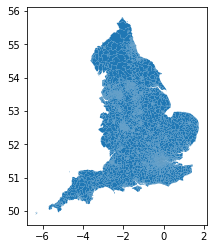

In [7]:
tract.plot()

形成表格

In [8]:
ntw_dist_piv = network_distance.pivot_table(values="Distance in meter", index="origin_id", columns="destination_id")
ntw_dist_piv

destination_id,22,24,28,31,37,54,58,64,76,79,94,100,102,105,109,155,156,159,168,183,184,188,191,209,231,251,254,260,262,281,283,293,294,296,297,312,324,338,345,346,...,21471,21474,21475,21479,21484,21485,21488,21489,21490,21498,21499,21506,21515,21521,21539,21543,21546,21556,21562,21568,21571,21574,21602,21606,21628,21630,21631,21654,21662,21695,21747,21753,21762,21764,21772,21777,21783,21789,21801,21802
origin_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
E02002527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02002692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02002693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02002694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02002695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02006845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8585.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02006846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4558.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02006857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4083.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4263.6,5705.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14115.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


形成矩阵

In [9]:
cost_matrix = ntw_dist_piv.to_numpy()
cost_matrix

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

由于存在空值nan，空值为MSOA与POI之间无法提供疫苗服务，而能够提供服务的距离10英里为16093.44公里，因此，将空值填补为20000公里。

In [10]:
cost_matrix[numpy.isnan(cost_matrix)] = 20000

In [11]:
cost_matrix

array([[20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       ...,
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.]])

In [12]:
facility_points_gdf = geopandas.GeoDataFrame(
    facility_points,
    geometry=geopandas.points_from_xy(
        facility_points.point_lon, facility_points.point_lat
    ),
).sort_values(by=['index']).reset_index()

demand_points_gdf = geopandas.GeoDataFrame(
    demand_points,
    geometry=geopandas.points_from_xy(demand_points.point_lon, demand_points.point_lat),
).sort_values(by=['msoa11cd']).reset_index()

In [13]:
facility_points_gdf

,level_0,name_id,name,point_lon,point_lat,index,geometry
0,0,22,Seaton & District Community Hospital,-3.071506,50.711803,1,POINT (-3.07151 50.71180)
1,1,24,Radcliffe Day and Night Pharmacy,-1.039834,52.947186,2,POINT (-1.03983 52.94719)
2,2,28,Leek Pharmacy,-2.007594,53.114610,3,POINT (-2.00759 53.11461)
3,3,31,Rosebird Centre Pharmacy,-1.698512,52.179296,4,POINT (-1.69851 52.17930)
4,4,37,Anglia Community Eye Service,0.141951,52.648342,5,POINT (0.14195 52.64834)
...,...,...,...,...,...,...,...
2733,2733,21777,Crown Chiropractic Clinic,0.551217,51.877829,2734,POINT (0.55122 51.87783)
2734,2734,21783,Highworth Physiotherapy Clinic,-1.710237,51.630451,2735,POINT (-1.71024 51.63045)
2735,2735,21789,Chepstow Clinic,-2.673831,51.642387,2736,POINT (-2.67383 51.64239)
2736,2736,21801,Derbyshire Healthcare Trust,-1.553070,53.138007,2737,POINT (-1.55307 53.13801)


In [14]:
demand_points_gdf

,level_0,index,objectid,msoa11cd,point_lon,point_lat,geometry
0,0,1,311,E02002527,-0.895104,54.556813,POINT (-0.89510 54.55681)
1,1,2,1636,E02002692,-0.900405,53.979796,POINT (-0.90041 53.97980)
2,2,3,1634,E02002693,-0.271017,53.945190,POINT (-0.27102 53.94519)
3,3,4,1632,E02002694,-0.778200,53.931540,POINT (-0.77820 53.93154)
4,4,5,1631,E02002695,-0.168981,53.909875,POINT (-0.16898 53.90988)
...,...,...,...,...,...,...,...
375,375,376,6413,E02006845,-2.906422,51.358374,POINT (-2.90642 51.35837)
376,376,377,6410,E02006846,-2.929576,51.347977,POINT (-2.92958 51.34798)
377,377,378,5000,E02006857,0.313122,50.786367,POINT (0.31312 50.78637)
378,378,379,1484,E02006870,-0.786744,54.132341,POINT (-0.78674 54.13234)


In [15]:
service_dist = 16093.44

定义plot_results函数

In [ ]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

def plot_results(model, facility_points_gdf, demand_points_gdf, facility_count, title):
    arr_points = []
    fac_sites = []
    
    for i in range(facility_count):
        if model.fac2cli[i]:
            geom = demand_points_gdf.iloc[model.fac2cli[i]]['geometry']
            arr_points.append(geom)
            fac_sites.append(i)

    fig, ax = plt.subplots(figsize=(18,18))
    legend_elements = []

    tract.plot(ax=ax, alpha=1, color='tan', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='tan',
        label='tract',
    ))

    facility_points_gdf.plot(ax=ax, color='brown', marker=".", markersize=5, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={facility_count})'
    ))

    demand_points_gdf.plot(ax=ax, edgecolor='k', color='white', zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='white',
        marker="o",
        markeredgecolor='k',
        linewidth=0,
        label=f'clients not covered'
    ))
 
    for i in range(len(arr_points)):
        gdf = geopandas.GeoDataFrame(arr_points[i])
        #print(fac_sites[i])
        label = f"points covered by {facility_points_gdf.iloc[[fac_sites[i]]]['index'].squeeze()}"
        legend_elements.append(Patch(facecolor=dv_colors[1], edgecolor="k", label=label))

        gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color='white',label=label)
        facility_points_gdf.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[1])
        
        legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[1],
            marker="*",
            ms=20 / 2,
            markeredgecolor="k",
            linewidth=0,
            alpha=0.8,
            label=f"{facility_points_gdf.iloc[[fac_sites[i]]]['index'].squeeze()}",
        ))

    plt.title(title, fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

In [19]:
m=demand_points.drop(['geometry'],axis=1)

In [20]:
n = pandas.merge(left = tract,right = m, how='right', left_on='MSOA11CD', right_on='msoa11cd')

In [21]:
n

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,index,objectid,msoa11cd,point_lon,point_lat
0,E02002527,Redcar and Cleveland 013,3094,709,573,484,159,59,5078,"POLYGON ((-0.89730 54.57188, -0.89957 54.56414...",1,311,E02002527,-0.895104,54.556813
1,E02002692,East Riding of Yorkshire 009,4692,1490,1303,1090,396,108,9079,"POLYGON ((-0.86687 53.92263, -0.87111 53.92103...",2,1636,E02002692,-0.900405,53.979796
2,E02002693,East Riding of Yorkshire 010,3247,1271,1167,1040,372,59,7156,"POLYGON ((-0.21131 54.00579, -0.20984 54.00176...",3,1634,E02002693,-0.271017,53.945190
3,E02002694,East Riding of Yorkshire 011,6305,1925,1585,1479,694,136,12124,"POLYGON ((-0.70490 54.00607, -0.72614 54.00029...",4,1632,E02002694,-0.778200,53.931540
4,E02002695,East Riding of Yorkshire 012,3631,1197,1366,1367,628,116,8305,"POLYGON ((-0.10074 53.84693, -0.12496 53.84431...",5,1631,E02002695,-0.168981,53.909875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E02006845,North Somerset 026,6772,1147,884,672,320,102,9897,"POLYGON ((-2.84262 51.35541, -2.85650 51.34311...",376,6413,E02006845,-2.906422,51.358374
376,E02006846,North Somerset 027,7366,955,506,288,117,17,9249,"POLYGON ((-2.91534 51.34922, -2.93358 51.34443...",377,6410,E02006846,-2.929576,51.347977
377,E02006857,Eastbourne 013,4821,1221,1108,1153,521,134,8958,"POLYGON ((0.30640 50.79866, 0.30885 50.79686, ...",378,5000,E02006857,0.313122,50.786367
378,E02006870,Ryedale 008,8386,2059,1673,1378,799,190,14485,"POLYGON ((-0.73979 54.17064, -0.73213 54.16706...",379,1484,E02006870,-0.786744,54.132341


In [22]:
tract['dissolve']=1
MSOA_outline = tract.dissolve(by='dissolve')

In [18]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

def plot_results(model, facility_points_gdf, demand_points_gdf, facility_count, title):
    arr_points = []
    fac_sites = []
    
    for i in range(facility_count):
        if model.fac2cli[i]:
            geom = demand_points_gdf.iloc[model.fac2cli[i]]['geometry']
            arr_points.append(geom)
            fac_sites.append(i)

    fig, ax = plt.subplots(figsize=(18,18))
    legend_elements = []
    n.plot(figsize = (18,18),ax=ax,zorder=1)
    MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
    #tract.plot(ax=ax, alpha=1, color='tan', zorder=1)
    legend_elements.append(Patch(edgecolor=(0.8, 0, 0,0.8), label='MSOAs Lack of Vaccination Service'))
    legend_elements.append(Patch(edgecolor=(0.8, 0, 0,0.8),facecolor='none',label='MSOAs with Vaccination Service'))
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='orange',
        marker='*',
        markersize=16,
        markeredgecolor="k",
        linewidth=0,
        label='Location of Vaccine Station'
        ))
    # legend_elements.append(mlines.Line2D(
    #     [],
    #     [],
    # #   color='tan',
    #     label='tract',
    # ))

    # facility_points_gdf.plot(ax=ax, color='brown', marker="*", markersize=30, zorder=2)
    # legend_elements.append(mlines.Line2D(
    #     [],
    #     [],
    #     color='brown',
    #     marker="*",
    #     linewidth=0,
    #     label=f'facility sites ($n$={facility_count})'
    # ))

    # demand_points_gdf.plot(ax=ax, color='white', marker='*' ,markersize=30,edgecolor="k", zorder=2)
    # legend_elements.append(mlines.Line2D(
    #     [],
    #     [],
    #     color='white',
    #     marker="*",
    #     linewidth=0,
    #     label=f'clients not covered'
    # ))
 
    for i in range(len(arr_points)):
        gdf = geopandas.GeoDataFrame(arr_points[i])
        #print(fac_sites[i])
        label = f"points covered by {facility_points_gdf.iloc[[fac_sites[i]]]['index'].squeeze()}"
        #legend_elements.append(Patch(facecolor=dv_colors[1], edgecolor="k", label=label))

        # gdf.plot(ax=ax, zorder=3, alpha=0.7, color='white',markersize=10,label=label)
        facility_points_gdf.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor='orange')
        
        # legend_elements.append(mlines.Line2D(
        #     [],
        #     [],
        #     color=dv_colors[1],
        #     marker="*",
        #     ms=20 / 2,
        #     markeredgecolor="k",
        #     linewidth=0,
        #     alpha=0.8,
        #     label=f"{facility_points_gdf.iloc[[fac_sites[i]]]['index'].squeeze()}",
        # ))
    # plt.tight_layout() 
    plt.title(title, fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

调用LSCP函数，并运行

In [16]:
from spopt.locate.coverage import LSCP

In [ ]:
!sudo apt-get install python-glpk
!sudo apt-get install glpk-utils

In [23]:
lscp = LSCP.from_cost_matrix(cost_matrix, service_dist)
lscp = lscp.solve(pulp.GLPK(msg=False))

lscp.facility_client_array()
# plot_results(lscp, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "LSCP")

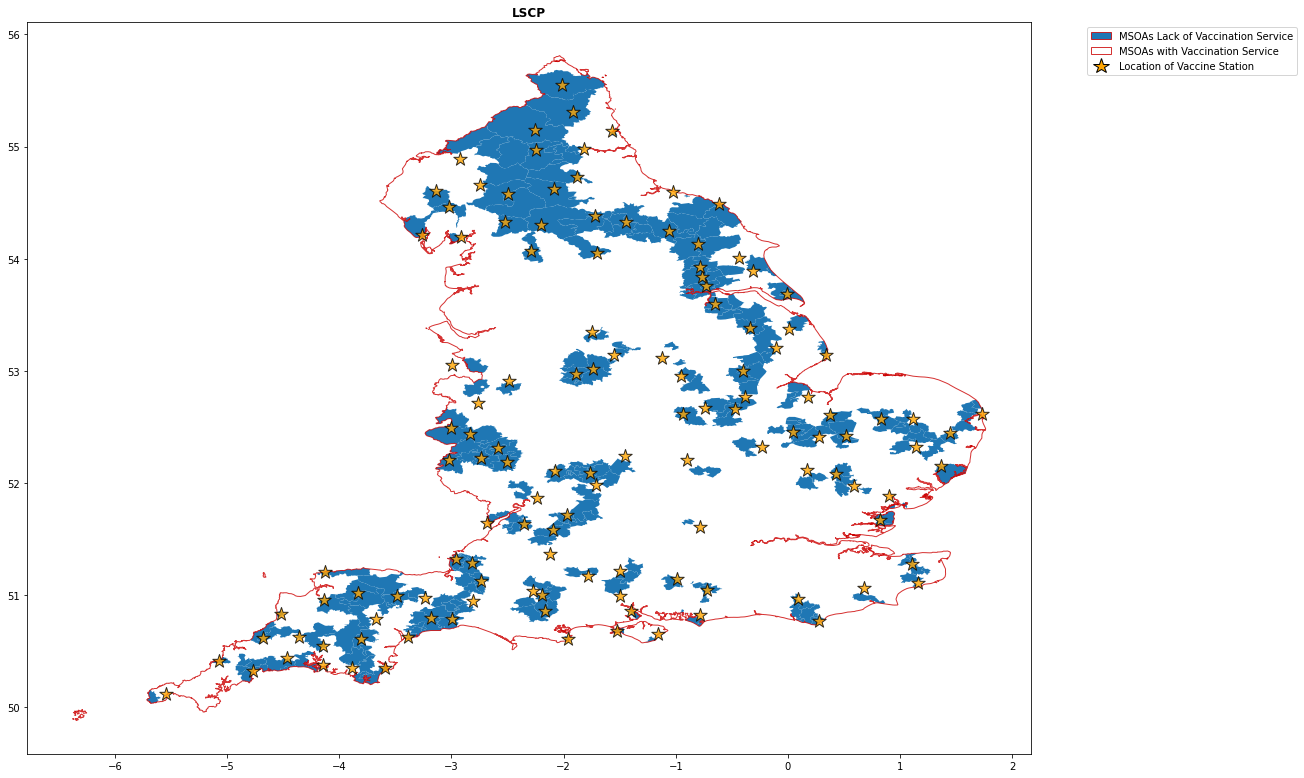

In [ ]:
plot_results(lscp, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "LSCP")

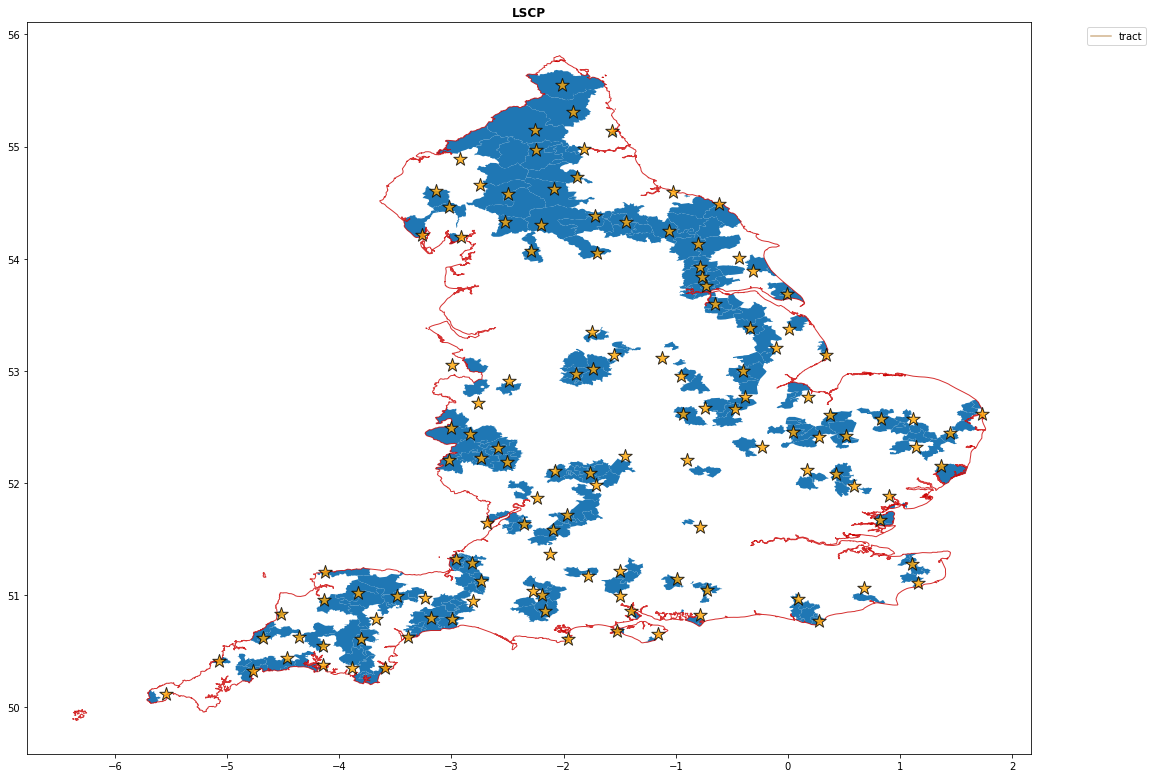

In [ ]:
plot_results(lscp, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "LSCP")